# Data Madness
## Group 2

### authors:
* Simon Garland
* PierrePaul Charbonnier
* Filip Straka

Department of Advanced Computing Sciences
Maastricht University
March 2024

NB1: all data was publicly available at https://ratings.fide.com/download.phtml?period=2024-01-01
#
NB2: all our initial considerations are written out in the accompanying initial_considerations file appended
#
NB3: a more friendly presentation can be found in the data_analysis.pptx

### Let's start!

## 1. Initial Data processing

Let's begin with extracting the data from the ZIP files (they'll grow tremendously)

In [5]:
import os.path

# NB: im doing it on a small fraction of the data now to prevent my laptop from blowing up ever so nicely

## imports ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

### vvvvvvvvvv      set your data here      vvvvvvvvvv

a.k.a. define the modes, years, and months you want to include

In [6]:
# define all possible files
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
          'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
years = ['21','22','23','24']
year21 = ['21']
year22 = ['22']
year23 = ['23']
year24 = ['24']
modes = ["standard"]  # "rapid", "blitz"

In [7]:
for month in months:
    for mode in modes:
        for year in years:
            path = '../data_zipped/'+mode+"_"+month+year+"frl_xml.zip"
            if os.path.exists(path):
                with zipfile.ZipFile(path, 'r') as zip_ref:
                    zip_ref.extractall('../data_unzipped')

In [8]:
lst_std = []
lst_rapid = []
lst_blitz = []

In [9]:
def xml_to_list(months_, years_, mode_):
    lst = []
    for month_ in months_:
        for year_ in years_:
            path_ = '../data_unzipped/'+mode_+"_"+month_+year_+"frl_xml.xml"
            if os.path.exists(path_):
                df = pd.read_xml(path_)
                # making sure we don't add useless people
                df.dropna(subset=['rating', 'birthday',
                          'sex', 'name', 'country'])
                df.add_suffix(month_+year_)
                df.head(10)
                lst.append(df)
    return lst

### vvvvvvvvvv      get your data here      vvvvvvvvvv

In [10]:
lst_std_21 = xml_to_list(months, year21, "standard")

lst_std_22 = xml_to_list(months, year22, "standard")

lst_std_23 = xml_to_list(months, year23, "standard")

lst_std_24 = xml_to_list(months, year24, "standard")

lst_rapid_21 = xml_to_list(months, year21, "rapid")

lst_rapid_22 = xml_to_list(months, year22, "rapid")

lst_rapid_23 = xml_to_list(months, year23, "rapid")

lst_rapid_24 = xml_to_list(months, year24, "rapid")

lst_blitz_21 = xml_to_list(months, year21, "blitz")

lst_blitz_22 = xml_to_list(months, year22, "blitz")

lst_blitz_23 = xml_to_list(months, year23, "blitz")

lst_blitz_24 = xml_to_list(months, year24, "blitz")

Converting lists to Pandas Dataframes - keeping the chronological order of the months in a year by appending indices (0-11)


NB: 2021 has only 9 months (april to december), and 2024 has only 3 months - making this analysis study a three year span in total

In [11]:
def lst_to_df(lst):
    for i in range(len(lst)):
        lst[i] = lst[i].add_suffix('_'+str(i))
        lst[i].set_index('fideid_'+str(i), inplace=True)

    combined_df = lst[0]
    for i in range(1, len(lst)):
        combined_df = combined_df.combine_first(lst[i])

    return combined_df

In [12]:
df_std_21 = lst_to_df(lst_std_21)
df_std_22 = lst_to_df(lst_std_22)
df_std_23 = lst_to_df(lst_std_23)
df_std_24 = lst_to_df(lst_std_24)

df_rapid_21 = lst_to_df(lst_rapid_21)
df_rapid_22 = lst_to_df(lst_rapid_22)
df_rapid_23 = lst_to_df(lst_rapid_23)
df_rapid_24 = lst_to_df(lst_rapid_24)

df_blitz_21 = lst_to_df(lst_blitz_21)
df_blitz_22 = lst_to_df(lst_blitz_22)
df_blitz_23 = lst_to_df(lst_blitz_23)
df_blitz_24 = lst_to_df(lst_blitz_24)

## 2. Regressing on past ratings, obtaining future ratings

Here we will try to look at past ratings of both sexes (male and female), and we will try to estimate new, future ratings based on it. We will also discuss all our findings and the cause of them.

Helper methods

In [13]:
def calculate_median_ratings(dfs, gender, ratings_per_df):

    median_ratings = []
    for df, ratings_count in zip(dfs, ratings_per_df):
        for i in range(ratings_count):
            gender_col = f'sex_{i}'
            rating_col = f'rating_{i}'

            if gender_col in df.columns:
                median = df[df[gender_col] == gender][rating_col].median()
                median_ratings.append(median)
            else:
                print("eeeeeeeeeee")
                median_ratings.append(None)

    return median_ratings

def calculate_mean_ratings(dfs, gender, ratings_per_df):
    mean_ratings = []
    for df, ratings_count in zip(dfs, ratings_per_df):
            for i in range(ratings_count):
                gender_col = f'sex_{i}'
                rating_col = f'rating_{i}'

                if gender_col in df.columns:
                    median = df[df[gender_col] == gender][rating_col].mean()
                    mean_ratings.append(median)
                else:
                    print("eeeeeee")
                    mean_ratings.append(None)
    return mean_ratings


Create a list of dataframes so to not get confused later on

In [ ]:
dataframes_std = [df_std_21, df_std_22, df_std_23, df_std_24]
dataframes_rapid = [df_rapid_21, df_rapid_22, df_rapid_23, df_rapid_24]
dataframes_blitz = [df_blitz_21, df_blitz_22, df_blitz_23, df_blitz_24]

Have a helper array to know how many months we have in each year

In [ ]:
ratings_per_df_std = [9, 12, 12, 2]
ratings_per_df_rapid = [9, 12, 12, 2]
ratings_per_df_blitz = [9, 12, 12, 2]

Calculate medians and means for female and male players from April 2021 to March 2024 (excluded - reason visualized later on)

In [ ]:
median_females_std = calculate_median_ratings(dataframes_std, 'F', ratings_per_df_std)
median_females_rapid = calculate_median_ratings(dataframes_rapid, 'F', ratings_per_df_rapid)
median_females_blitz = calculate_median_ratings(dataframes_blitz, 'F', ratings_per_df_blitz)

In [ ]:
mean_females_std= calculate_mean_ratings(dataframes_std, 'F', ratings_per_df_std)
mean_females_rapid = calculate_mean_ratings(dataframes_rapid, 'F', ratings_per_df_rapid)
mean_females_blitz = calculate_mean_ratings(dataframes_blitz, 'F', ratings_per_df_blitz)

In [ ]:
median_male_std=calculate_median_ratings(dataframes_std, 'M', ratings_per_df_std)
median_male_blitz=calculate_median_ratings(dataframes_blitz, 'M', ratings_per_df_blitz)
median_male_rapid=calculate_median_ratings(dataframes_rapid, 'M', ratings_per_df_rapid)

In [ ]:
mean_male_std=calculate_mean_ratings(dataframes_std, 'M', ratings_per_df_std)
mean_male_blitz=calculate_mean_ratings(dataframes_blitz, 'M', ratings_per_df_blitz)
mean_male_rapid=calculate_mean_ratings(dataframes_rapid, 'M', ratings_per_df_rapid)

Let's plot this temporal data for females - our instinct tells us that due to the CLT - the mean should follow the same distribution as the median

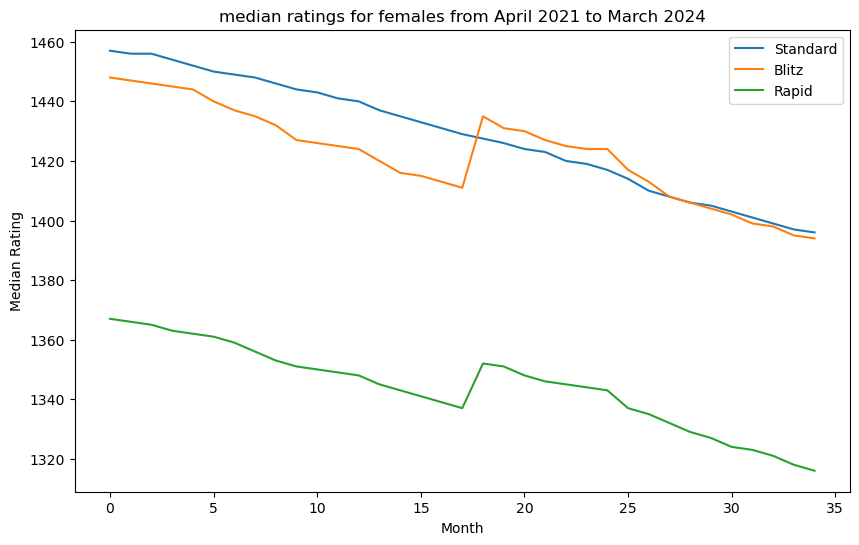

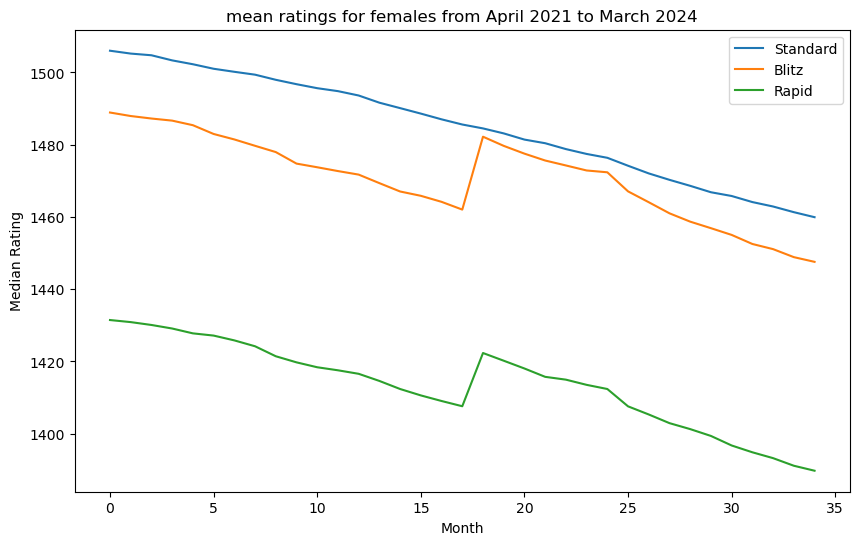

[1448.0, 1447.0, 1446.0, 1445.0, 1444.0, 1440.0, 1437.0, 1435.0, 1432.0, 1427.0, 1426.0, 1425.0, 1424.0, 1420.0, 1416.0, 1415.0, 1413.0, 1411.0, 1435.0, 1431.0, 1430.0, 1427.0, 1425.0, 1424.0, 1424.0, 1417.0, 1413.0, 1408.0, 1406.0, 1404.0, 1402.0, 1399.0, 1398.0, 1395.0, 1394.0]


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(median_females_std)
plt.plot(median_females_blitz)
plt.plot(median_females_rapid)

plt.legend(['Standard', 'Blitz', 'Rapid'])

plt.title('median ratings for females from April 2021 to March 2024')
plt.xlabel('Month')
plt.ylabel('Median Rating')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(mean_females_std)
plt.plot(mean_females_blitz)
plt.plot(mean_females_rapid)

plt.legend(['Standard', 'Blitz', 'Rapid'])

plt.title('mean ratings for females from April 2021 to March 2024')
plt.xlabel('Month')
plt.ylabel('Median Rating')

plt.show()

print(median_females_blitz)


We can see that they follow the same patter with a slight offset with an increase in October 2022

Now that we have seen these graphs - it follows that this looks like a very nice example of linear regression - so let's do it for females

Mean Squared Error for y: 2.1520899437667214
Mean Squared Error for z: 32.65933288234745
Mean Squared Error for w: 57.10039633626348


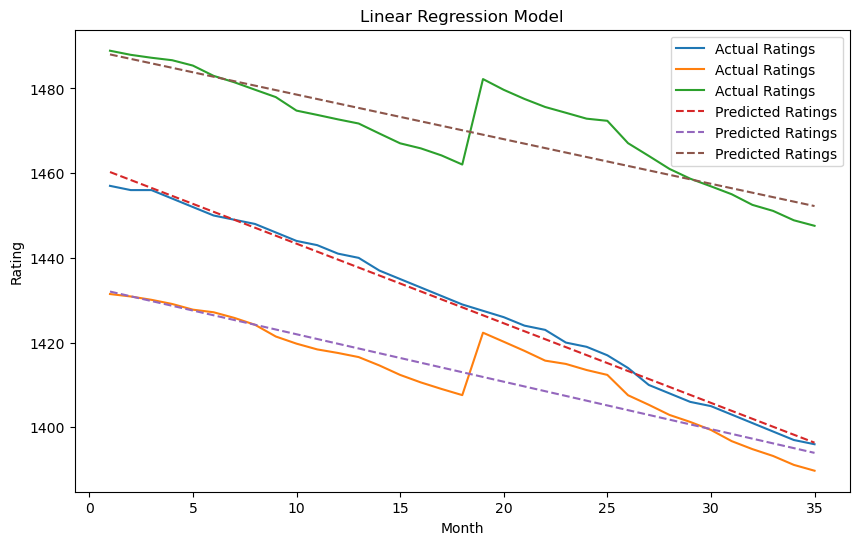

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = {
    'Month': list(range(1, 36)),
    'Standard_Rating': median_females_std,
    'Rapid_Rating': mean_females_rapid,
    'Blitz_Rating': mean_females_blitz
    }

df = pd.DataFrame(data)

X = df[['Month']]

y = df['Standard_Rating']
z= df['Rapid_Rating']
w= df['Blitz_Rating']

X1_train, X1_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X2_train, X2_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)
X3_train, X3_test, w_train, w_test = train_test_split(X, w, test_size=0.2, random_state=42)

model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

model1.fit(X1_train, y_train)
model2.fit(X2_train, z_train)
model3.fit(X3_train, w_train)

y_pred = model1.predict(X1_test)
z_pred = model2.predict(X2_test)
w_pred = model3.predict(X3_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for y: {mse}")
mse = mean_squared_error(z_test, z_pred)
print(f"Mean Squared Error for z: {mse}")
mse = mean_squared_error(w_test, w_pred)

print(f"Mean Squared Error for w: {mse}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Actual Ratings')
plt.plot(X, z, label='Actual Ratings')
plt.plot(X, w, label='Actual Ratings')
plt.plot(X, model1.predict(X), label='Predicted Ratings', linestyle='--')
plt.plot(X, model2.predict(X), label='Predicted Ratings', linestyle='--')
plt.plot(X, model3.predict(X), label='Predicted Ratings', linestyle='--')

plt.legend()
plt.title('Linear Regression Model')
plt.xlabel('Month')
plt.ylabel('Rating')
plt.show()

We can see that the sudden increase in October 2022 is causing these predictions to not fit so well for Blitz, or Rapid. However - Standard stays pretty much the same over the course of these months so this regression we are happy with

Let's do the same thing for males!

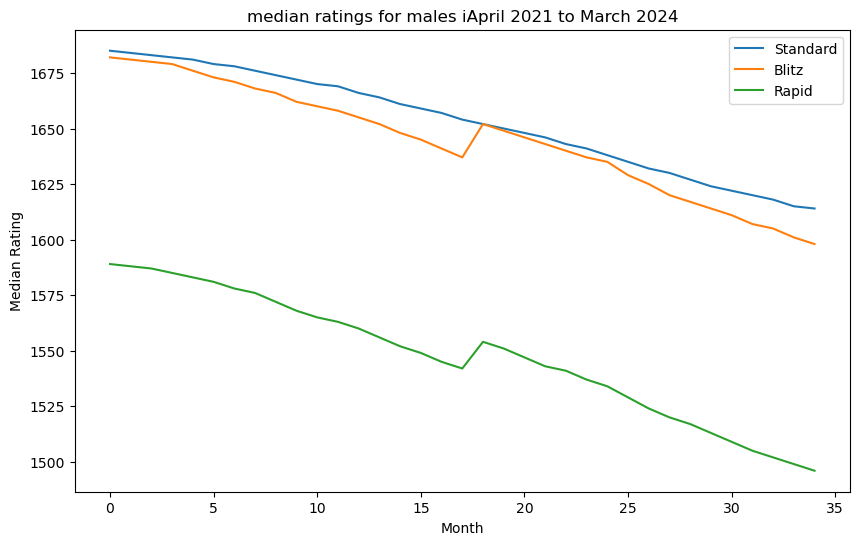

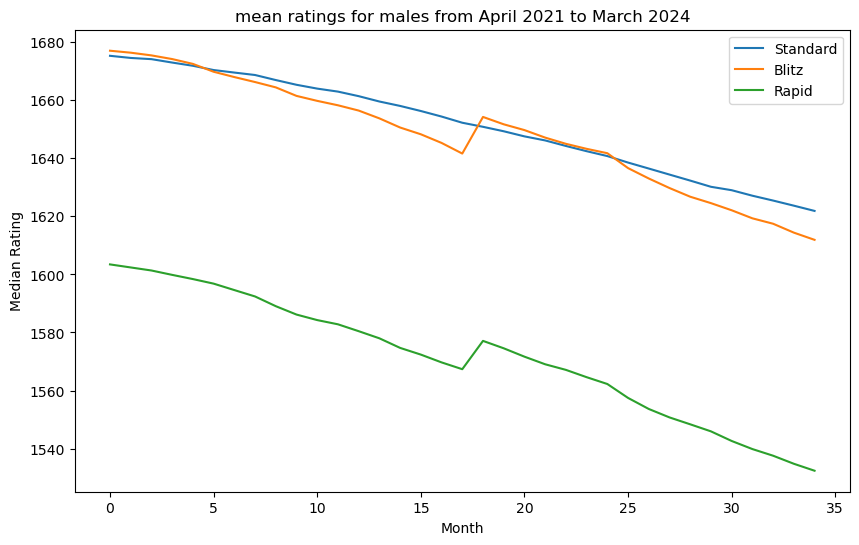

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(median_male_std)
plt.plot(median_male_blitz)
plt.plot(median_male_rapid)

plt.legend(['Standard', 'Blitz', 'Rapid'])
plt.title('median ratings for males iApril 2021 to March 2024')
plt.xlabel('Month')
plt.ylabel('Median Rating')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(mean_male_std)
plt.plot(mean_male_blitz)
plt.plot(mean_male_rapid)

plt.legend(['Standard', 'Blitz', 'Rapid'])

plt.title('mean ratings for males from April 2021 to March 2024')
plt.xlabel('Month')
plt.ylabel('Median Rating')

plt.show()

Mean Squared Error for y: 3.398436991998551
Mean Squared Error for z: 19.78280532861632
Mean Squared Error for w: 24.69245590984254


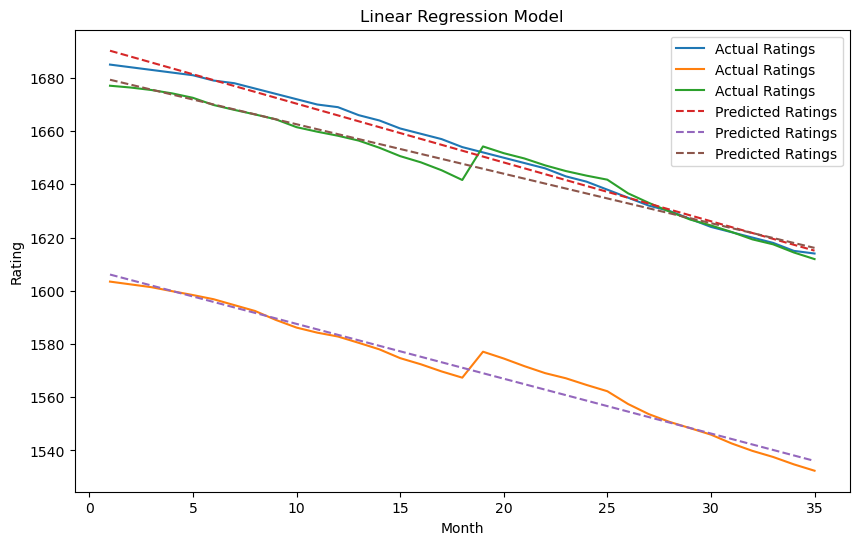

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = {
    'Month': list(range(1, 36)),
    'Standard_Rating': median_male_std,
    'Rapid_Rating': mean_male_rapid,
    'Blitz_Rating': mean_male_blitz
    }

df = pd.DataFrame(data)

X = df[['Month']]

y = df['Standard_Rating']
z= df['Rapid_Rating']
w= df['Blitz_Rating']

X1_train, X1_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X2_train, X2_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)
X3_train, X3_test, w_train, w_test = train_test_split(X, w, test_size=0.2, random_state=42)

model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

model1.fit(X1_train, y_train)
model2.fit(X2_train, z_train)
model3.fit(X3_train, w_train)

y_pred = model1.predict(X1_test)
z_pred = model2.predict(X2_test)
w_pred = model3.predict(X3_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for y: {mse}")
mse = mean_squared_error(z_test, z_pred)
print(f"Mean Squared Error for z: {mse}")
mse = mean_squared_error(w_test, w_pred)

print(f"Mean Squared Error for w: {mse}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Actual Ratings')
plt.plot(X, z, label='Actual Ratings')
plt.plot(X, w, label='Actual Ratings')
plt.plot(X, model1.predict(X), label='Predicted Ratings', linestyle='--')
plt.plot(X, model2.predict(X), label='Predicted Ratings', linestyle='--')
plt.plot(X, model3.predict(X), label='Predicted Ratings', linestyle='--')

plt.legend()
plt.title('Linear Regression Model')
plt.xlabel('Month')
plt.ylabel('Rating')
plt.show()

Mean Squared Error for y: 1.906743977163839
Mean Squared Error for z: 19.78280532861632
Mean Squared Error for w: 24.69245590984254


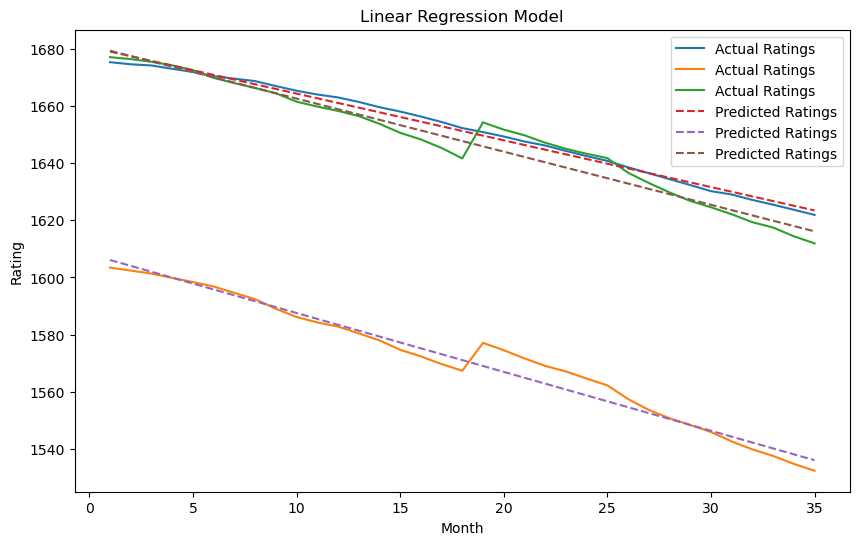

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = {
    'Month': list(range(1, 36)),
    'Standard_Rating': mean_male_std,
    'Rapid_Rating': mean_male_rapid,
    'Blitz_Rating': mean_male_blitz
    }

df = pd.DataFrame(data)

X = df[['Month']]

y = df['Standard_Rating']
z= df['Rapid_Rating']
w= df['Blitz_Rating']

X1_train, X1_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X2_train, X2_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)
X3_train, X3_test, w_train, w_test = train_test_split(X, w, test_size=0.2, random_state=42)

model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

model1.fit(X1_train, y_train)
model2.fit(X2_train, z_train)
model3.fit(X3_train, w_train)

y_pred = model1.predict(X1_test)
z_pred = model2.predict(X2_test)
w_pred = model3.predict(X3_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for y: {mse}")
mse = mean_squared_error(z_test, z_pred)
print(f"Mean Squared Error for z: {mse}")
mse = mean_squared_error(w_test, w_pred)

print(f"Mean Squared Error for w: {mse}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Actual Ratings')
plt.plot(X, z, label='Actual Ratings')
plt.plot(X, w, label='Actual Ratings')
plt.plot(X, model1.predict(X), label='Predicted Ratings', linestyle='--')
plt.plot(X, model2.predict(X), label='Predicted Ratings', linestyle='--')
plt.plot(X, model3.predict(X), label='Predicted Ratings', linestyle='--')

plt.legend()
plt.title('Linear Regression Model')
plt.xlabel('Month')
plt.ylabel('Rating')
plt.show()


We can see that a very similar trend emerges for male players here. Only the Standard game mode did not get influenced by the October 2022 spike. Let's see what the numbers tell us:


For the Standard mode, an MSE of 1.9067 indicates that the predictions of the linear regression model are very close to the actual ratings, which is excellent, particularly because the rating scale is large.
For the Rapid mode, an MSE of 19.7828 is higher - this model's predictions are less accurate (looking at the graph you can see it's not following the line overall - this is due to the regression being linear.
For the Blitz mode, the MSE is 24.6924, which is straight-up bad. We would need another type of regression to better capture this relationship... 

Or would we?

The spike of sudden interest in October 2022 can be potentially explained by two major events in the world of chess:
1. Hans Niemann Scandal (the alleged vibrating helper tool); for those curious - https://en.wikipedia.org/wiki/Carlsen%E2%80%93Niemann_controversy
2. Chess going viral. Chess was beginning to become popular again in late october 2022 which brought back in a lot of players which can suggest rating increase, as well as decrease (virtually unpredictable if we don't have the data of what players joined. Again, for those curious - some Google Trends - https://trends.google.com/trends/explore?date=today%205-y&gprop=youtube&q=chess&hl=en

We think this is more of an outlier than anything else. Let's continue... 

We have also noticed something rather strange about the March 2024 ratings that did not make much sense, take a look here...

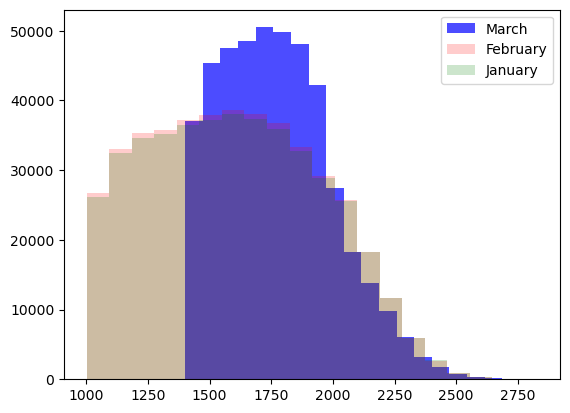

In [53]:
plt.hist(df_std_24['rating_2'], bins=20, color='blue', alpha=0.7)
plt.hist(df_std_24['rating_1'], bins=20, color='red', alpha=0.2)
plt.hist(df_std_24['rating_0'], bins=20, color='green', alpha=0.2)
plt.legend(['March', 'February', 'January'])
plt.show()


This distribution was not erroneously plotted. The reason behind this is an enforcement of new FIDE rules that botches our chances of prediction - read more about it here - https://qc.fide.com/2024/03/01/new-rating-regulations-come-into-force/

Essentially all the players were introduced with new ratings due to the new FIDE cutoff of rating 1400+ (which made the graphs skyrocket in the last month of our observations rendering any of our prediction efforts useless.
This can't be amended using another model - this requires lengthy data transformation which might not be very reliable. While we could try to predict future ratings not taking March 2024 into account, the ratings predicted would not be indicative of the real world. 

## 3. Who is dominant?

In this part - we try to see who is dominant with the demographics we were able to find in the FIDE dataset

How about the most represented countries over the year?

In [ ]:
country_columns = df_std_23.filter(like='country')

country_counts = country_columns.apply(pd.Series.value_counts, axis=0).fillna(0)

top_countries_df = country_counts.apply(lambda x: x.sort_values(ascending=False).head(5))

months = top_countries_df.columns
num_months = len(months)
print(num_months)
num_top_countries = len(top_countries_df.index)
colors = plt.cm.tab10.colors[:num_top_countries]

country_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

12


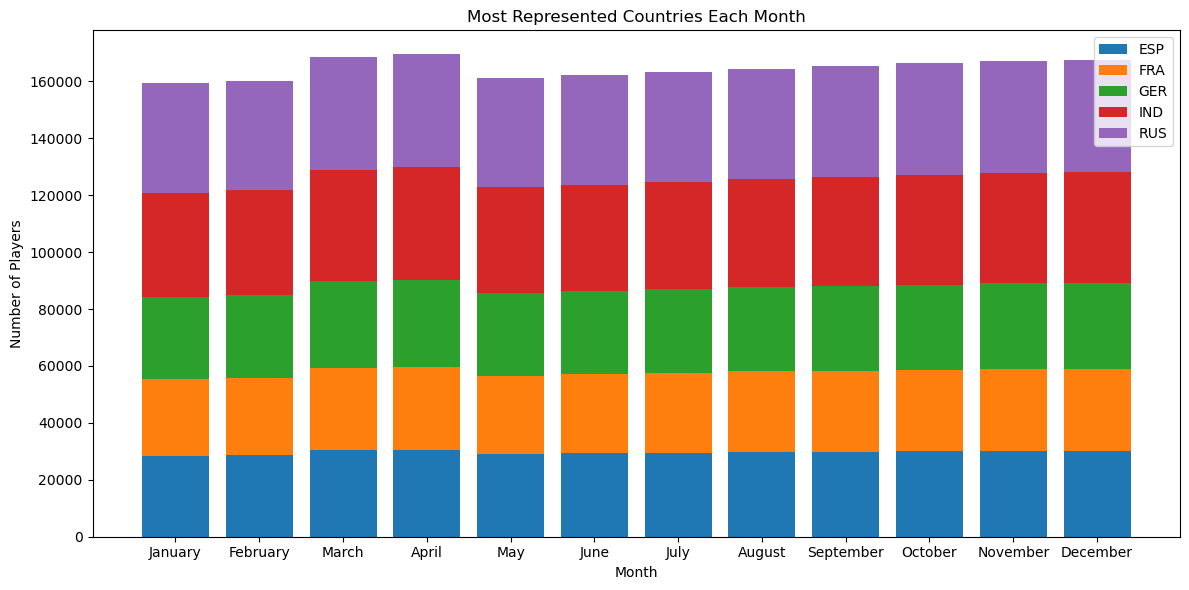

In [19]:
plt.figure(figsize=(12, 6))
for i, month in enumerate(months):
    bottom = None
    for j in range(num_top_countries):
        country = top_countries_df.index[j]
        count = top_countries_df.loc[country, month]
        plt.bar(i, count, bottom=bottom, label=country if i == 0 else None, color=colors[j])
        if bottom is None:
            bottom = count
        else:
            bottom += count

plt.xlabel('Month')
plt.ylabel('Number of Players')
plt.title('Most Represented Countries Each Month')
plt.xticks(range(num_months), country_months)
plt.legend()
plt.tight_layout()
plt.show()


Anybody who knows the chess scene even a little - they can confirm that Russia and India have the largest representation on the professional chess scene. So not a particularly useful finding - but certainly nice to know we are not wrong so far!

In [20]:
country_columns = df_std_23.filter(like='country')
country_counts = country_columns.apply(pd.Series.value_counts, axis=0).fillna(0)
bottom_countries_df = country_counts.apply(lambda x: x.sort_values(ascending=True).head(5))
bottom_countries_table = bottom_countries_df.rename(columns={"country_0": "January", "country_1": "February", "country_2": "March", "country_3": "April", "country_4": "May", "country_5": "June", "country_6": "July", "country_7": "August", "country_8": "September", "country_9": "October", "country_10": "November", "country_11": "December"})
bottom_countries_table = bottom_countries_table[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

print(bottom_countries_table)

     January  February  March  April  May  June  July  August  September  \
CHA      NaN       NaN    NaN    NaN  NaN   NaN   NaN     3.0        3.0   
COM      1.0       1.0    1.0    1.0  1.0   2.0   2.0     NaN        NaN   
GRN      0.0       0.0    0.0    0.0  1.0   1.0   1.0     1.0        1.0   
Ind      1.0       1.0    1.0    1.0  1.0   0.0   0.0     0.0        0.0   
NIG      0.0       0.0    0.0    0.0  0.0   0.0   0.0     1.0        1.0   
SKN      1.0       1.0    1.0    1.0  1.0   1.0   1.0     1.0        1.0   

     October  November  December  
CHA      3.0       3.0       3.0  
COM      NaN       NaN       NaN  
GRN      1.0       1.0       1.0  
Ind      0.0       0.0       0.0  
NIG      1.0       1.0       1.0  
SKN      1.0       1.0       1.0  


But what about the countries number of players they have overall and their average rating? Is there any nice distribution there?

In [ ]:
df_reset = df_std_23.reset_index()

df_melted = pd.wide_to_long(df_reset, stubnames=['country', 'rating'], i='index', j='month', sep='_', suffix=r'\w+').reset_index()

aggregated_data = df_melted.groupby('country').agg(
    num_players=('country', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

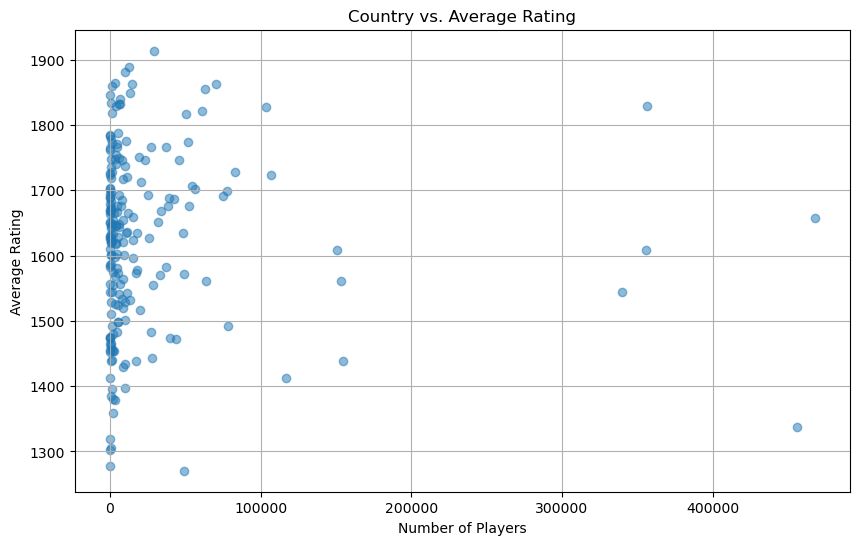

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(aggregated_data['num_players'], aggregated_data['avg_rating'], alpha=0.5)
plt.title('Country vs. Average Rating')
plt.xlabel('Number of Players')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()


This is rather hard to interpret. Maybe regressing upon it would be more helpful?

Linearly?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = aggregated_data[['num_players']]
y = aggregated_data['avg_rating']

model = LinearRegression()

model.fit(X, y)


slope = model.coef_[0]
intercept = model.intercept_


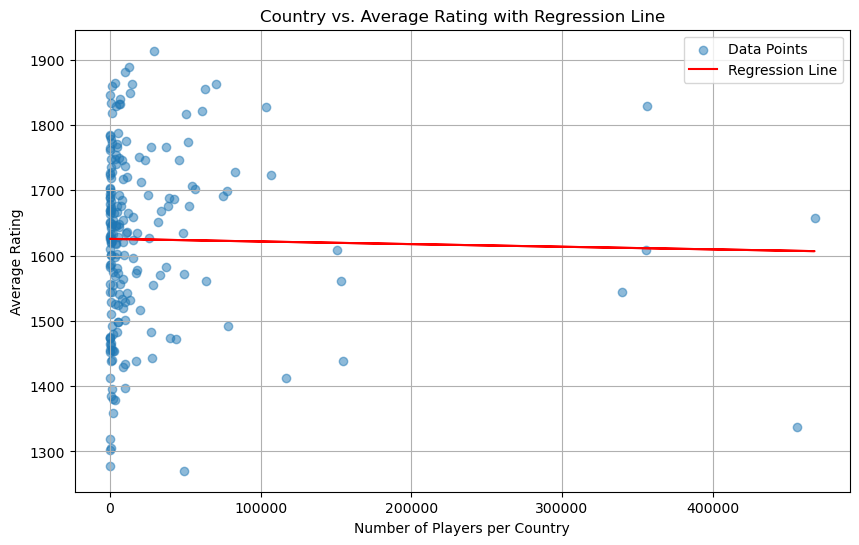

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data Points')  # Scatter plot of the data
plt.plot(X, model.predict(X), color='red', label='Regression Line')  # Regression line
plt.title('Country vs. Average Rating with Regression Line')
plt.xlabel('Number of Players per Country')
plt.ylabel('Average Rating')
plt.grid(True)
plt.legend()
plt.show()


the linear regression line seems to tell us even less...

Maybe a polynomial one?

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = aggregated_data[['num_players']]
y = aggregated_data['avg_rating'] 

degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

model.fit(X, y)

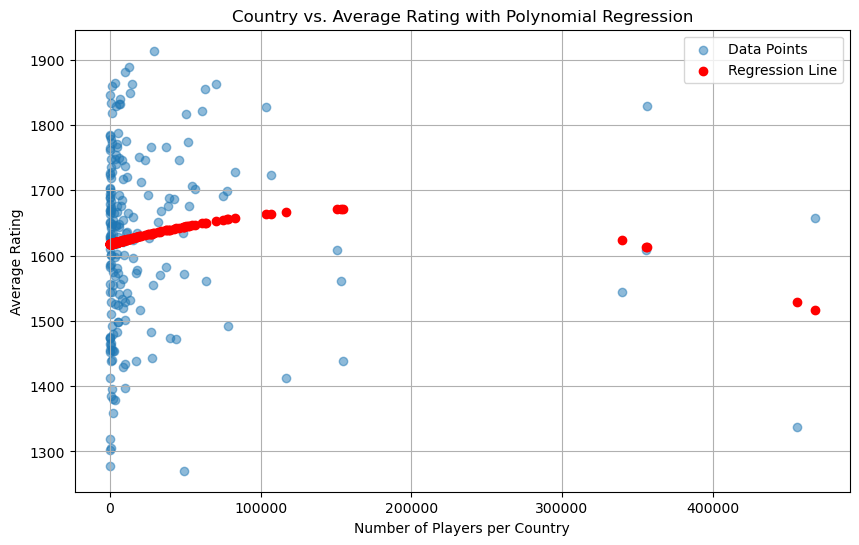

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data Points')  # Scatter plot of the data
plt.scatter(X, model.predict(X), color='red', label='Regression Line')  # Regression line
plt.title('Country vs. Average Rating with Polynomial Regression')
plt.xlabel('Number of Players per Country')
plt.ylabel('Average Rating')
plt.grid(True)
plt.legend()
plt.show()


Still not helpful. these do not seem to carry any sort of relationship.

Can we be sure about that though?

Yes - take a look right here...

In [ ]:
from scipy.stats import pearsonr, ttest_ind

corr, p_value = pearsonr(aggregated_data['num_players'], aggregated_data['avg_rating'])

print(f"Pearson Correlation: {corr}")
print(f"P-value: {p_value}")

group1 = aggregated_data[aggregated_data['num_players'] < 100]
group2 = aggregated_data[aggregated_data['num_players'] >= 100]

t_stat, p_value = ttest_ind(group1['avg_rating'], group2['avg_rating'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_melted['country'], df_melted['month'])

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Pearson Correlation: -0.019577052060901164
P-value: 0.7826647967923935
T-statistic: -1.6809310812507587
P-value: 0.09434514776833708
Chi-Square Statistic: 982.4921312891403
P-value: 1.0
Degrees of Freedom: 2200


not only is the correlation very low, the p-value is extremely high. We can conclude that these two indeed are not correlated

It looks like average ratings are not in any meaningful relationship with the amount of players a country has (which sounds obvious, but if there are many players, one could speculate there is a cultural aspect that influences the ratings - everybody plays, so I play too and I want to be the best of the best!).

What about the most prestigious thing beside winning a tournament? - How many titles per country?

In [ ]:
df_reset = df_std_23.reset_index()

df_melted = pd.wide_to_long(df_reset, stubnames=['country', 'title'], i='index', j='month', sep='_', suffix=r'\w+').reset_index()
df_melted =df_melted[df_melted['title'] != 'None']

aggregated_data = df_melted.groupby(['country', 'title']).size().unstack(fill_value=0)

total_titles_per_country = aggregated_data.sum(axis=1).sort_values(ascending=False).head(10)
top_countries = total_titles_per_country.index.tolist()

top_countries_data = aggregated_data.loc[top_countries]

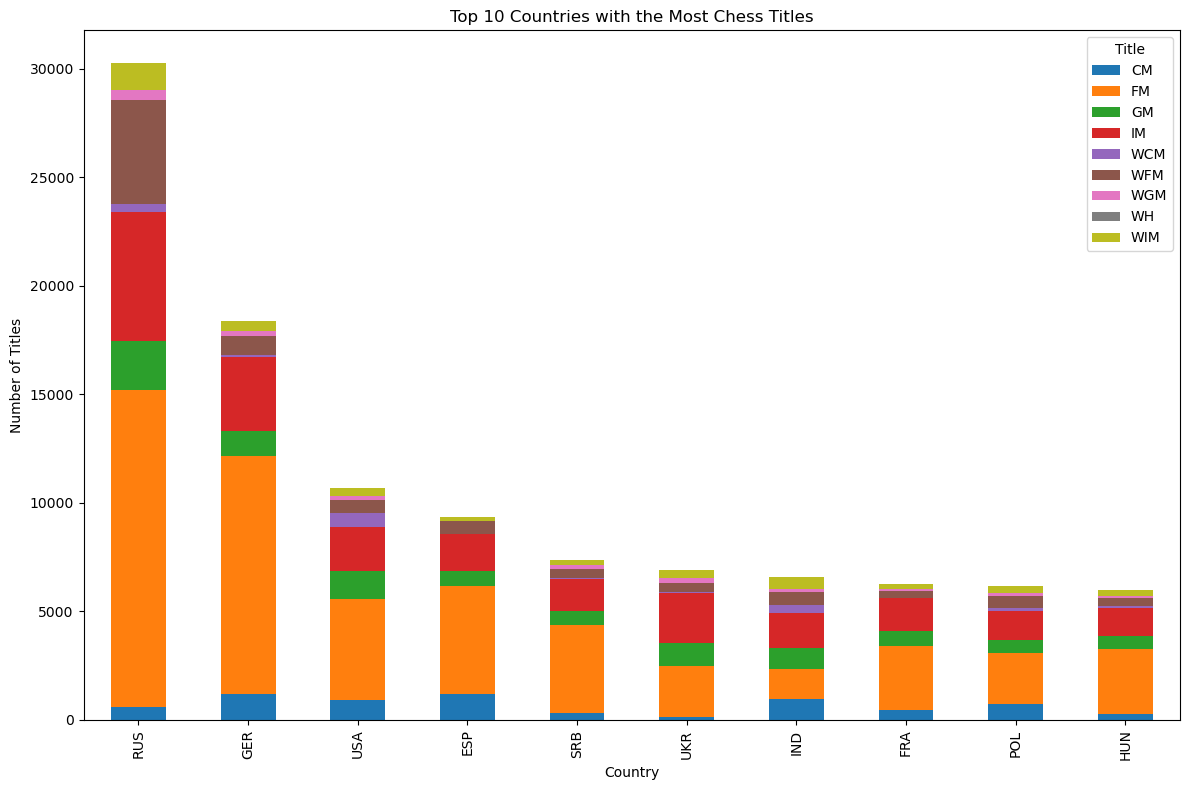

In [ ]:
top_countries_data.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Top 10 Countries with the Most Chess Titles')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.legend(title='Title')
plt.tight_layout()
plt.show()

Russia is clearly the winner in this aspect

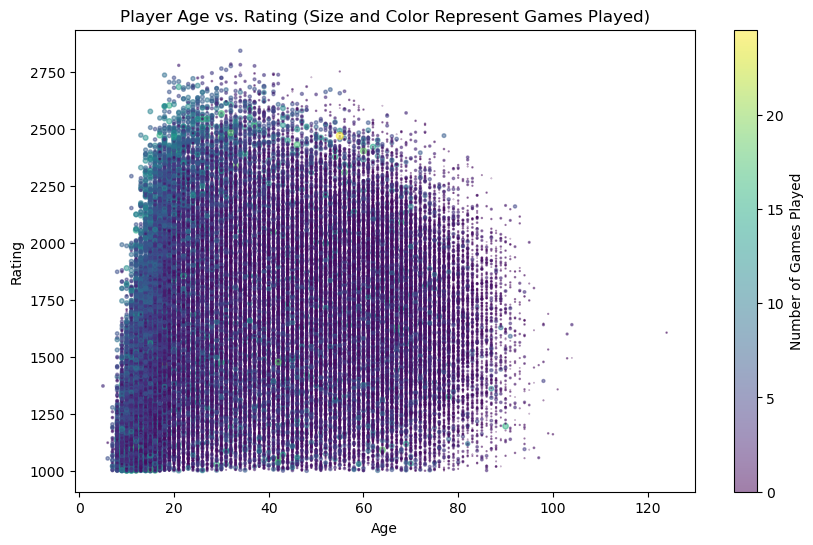

In [ ]:
for i in range(12):
    df_std_23['age_'+str(i)] = 2024 - df_std_23['birthday_'+str(i)]

df_reset = df_std_23.reset_index()

# Normalize the structure to 'long' format
df_melted = pd.wide_to_long(df_reset, stubnames=['age', 'rating', 'games'], i='index', j='month', sep='_', suffix=r'\w+').reset_index()

df_avg = df_melted.groupby('index').agg({'age': 'mean', 'rating': 'mean', 'games': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_avg['age'], df_avg['rating'], alpha=0.5, s=df_avg['games'], c=df_avg['games'], cmap='viridis')
plt.title('Player Age vs. Rating (Size and Color Represent Games Played)')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.colorbar(scatter, label='Number of Games Played')
plt.show()

Now while this is a very complicated graph - one thing we can carry away from this one is that the best chess players are currently in their 30s, 40s (Maximum of the graph)

Ok but what is the average age to have a particular title lately? 

In [ ]:
df_reset = df_std_23.reset_index()

# Normalize the structure to 'long' format
df_melted = pd.wide_to_long(df_reset, stubnames=['age', 'title'], i='index', j='month', sep='_', suffix=r'\w+').reset_index()

df_melted = df_melted[df_melted['title'] != 'None']

avg_age_by_title = df_melted.groupby('title')['age'].mean().reset_index()

print(avg_age_by_title)

  title        age
0    CM  39.551178
1    FM  48.241433
2    GM  45.346617
3    IM  48.362046
4   WCM  26.783447
5   WFM  36.656706
6   WGM  44.095177
7    WH  96.000000
8   WIM  42.045153


The WH title doesnt seem right - let's visualize this

Text(0.5, 1.0, 'Average Age per Chess Title')

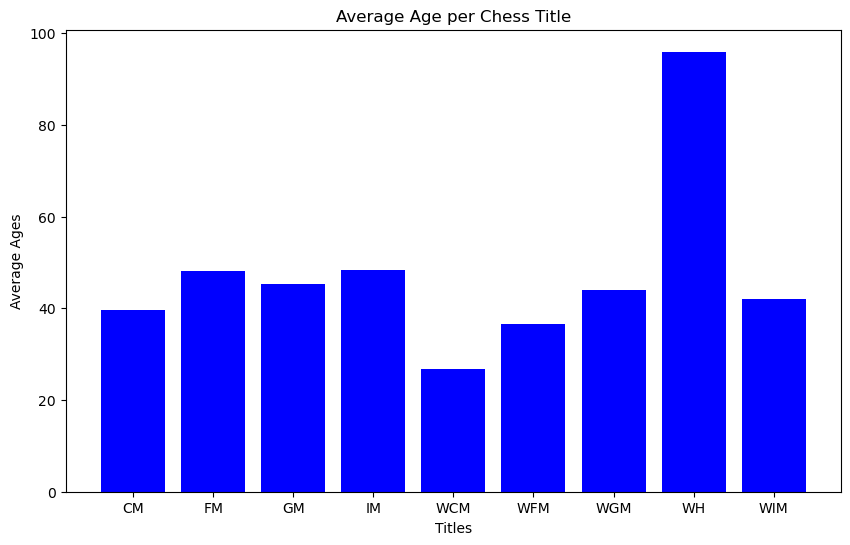

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(avg_age_by_title['title'], avg_age_by_title['age'], color="blue")
plt.xlabel("Titles")
plt.ylabel("Average Ages")
plt.title("Average Age per Chess Title")

The WH title does not exist - was a clear outlier of a female player instance - a fluke in the FIDE data

What about the average rating per country? Could give us some nice insights on the domination of the chess scene as to what nationality is the best...

Since we did not see any significant changes between two consecutive months (or a temporal trend) - we compare the following under the assumptions that no matter which month we analyze the results would be representative of the whole situation.

In [ ]:
average_rating_per_country_2021 = df_std_21[f"rating_0"].groupby(
df_std_21['country_0']).mean().sort_values(ascending=False).head(20)
average_rating_per_country_2022 = df_std_22[f"rating_0"].groupby(
df_std_22['country_0']).mean().sort_values(ascending=False).head(20)
average_rating_per_country_2023 = df_std_23[f"rating_0"].groupby(
df_std_23['country_0']).mean().sort_values(ascending=False).head(20)
average_rating_per_country_2024 = df_std_24[f"rating_0"].groupby(
df_std_24['country_0']).mean().sort_values(ascending=False).head(20)

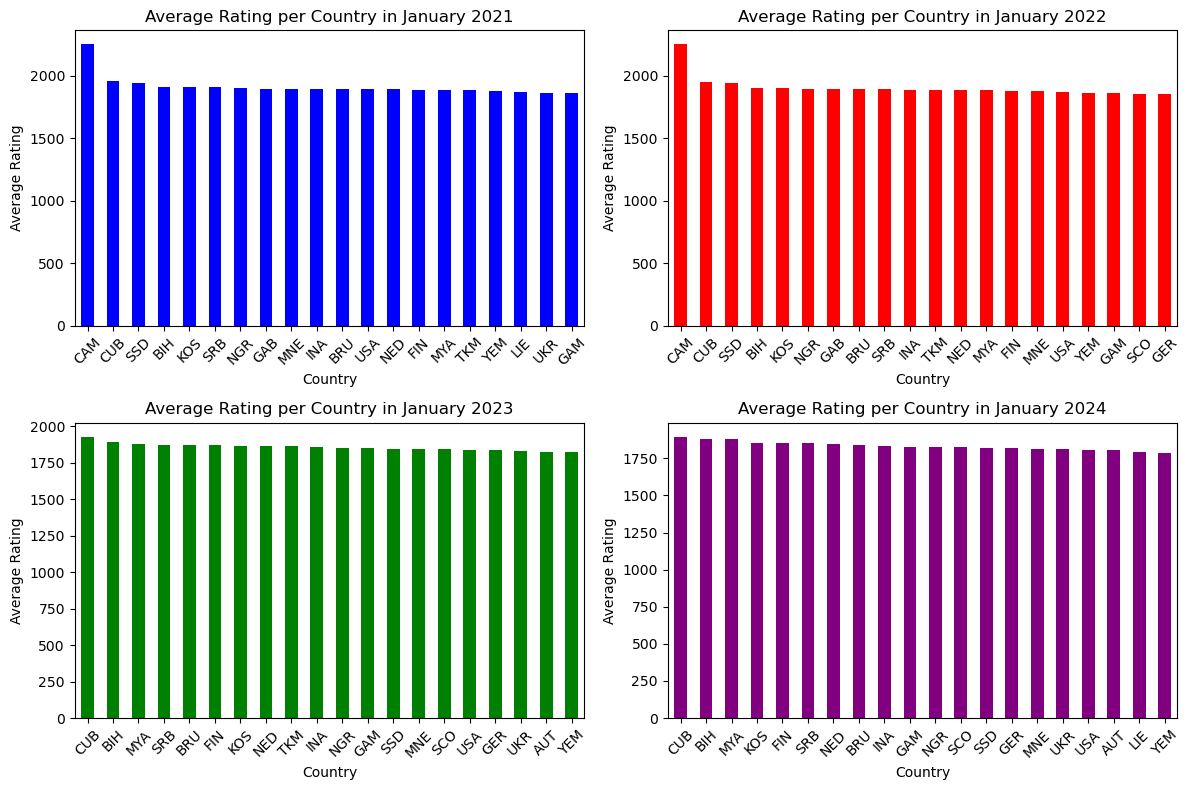

In [82]:


plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
average_rating_per_country_2021.plot(kind='bar', color='blue')
plt.title('Average Rating per Country in January 2021')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(2, 2, 2)
average_rating_per_country_2022.plot(kind='bar', color='red')
plt.title('Average Rating per Country in January 2022')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(2, 2, 3)
average_rating_per_country_2023.plot(kind='bar', color='green')
plt.title('Average Rating per Country in January 2023')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(2, 2, 4)
average_rating_per_country_2024.plot(kind='bar', color='purple')
plt.title('Average Rating per Country in January 2024')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()



CAM is the country with the highest average rating, but that is only because there is only 8 player from CAM in the dataset. This does not seem like a good approach to see who is the best. Let's try the largest representation on the chess scene?

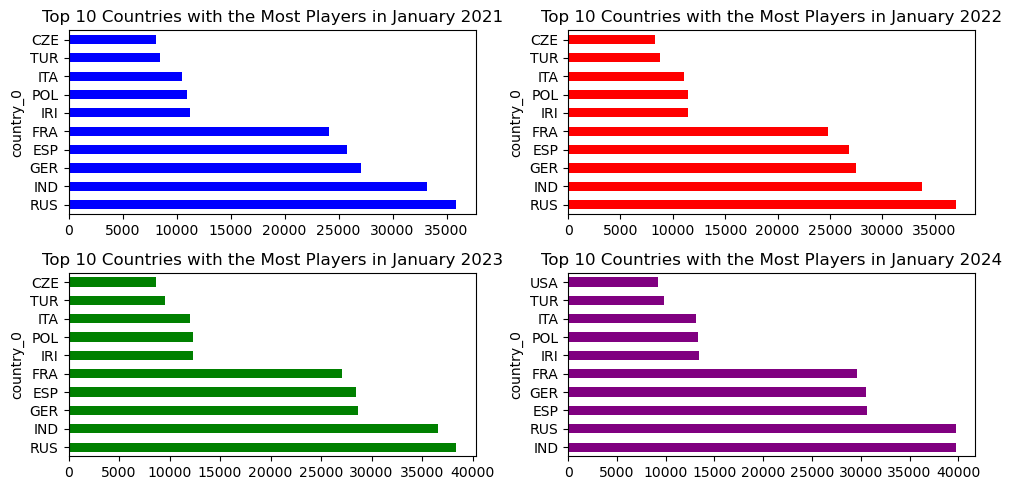

In [81]:
plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
plt.title('Top 10 Countries with the Most Players in January 2021')
average_rating_per_country_2021 = df_std_21['rating_0'].groupby(df_std_21['country_0']).count().sort_values(
    ascending=False).head(10).plot(kind='barh', figsize=(10, 5), color='blue')
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.title('Top 10 Countries with the Most Players in January 2022')
average_rating_per_country_2022 = df_std_22['rating_0'].groupby(df_std_22['country_0']).count().sort_values(
    ascending=False).head(10).plot(kind='barh', figsize=(10, 5), color='red')
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.title('Top 10 Countries with the Most Players in January 2023')
average_rating_per_country_2023 = df_std_23['rating_0'].groupby(df_std_23['country_0']).count().sort_values(
    ascending=False).head(10).plot(kind='barh', figsize=(10, 5), color='green')
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.title('Top 10 Countries with the Most Players in January 2024')
average_rating_per_country_2024 = df_std_24['rating_0'].groupby(df_std_24['country_0']).count().sort_values(
    ascending=False).head(10).plot(kind='barh', figsize=(10, 5), color='purple')
plt.tight_layout()


plt.show()



The top 100 players of each country is a better metric on "domination" since Russia and India are technically (and practically) dominating the scene on all levels. That's very little information though...

We saw that just taking the average is not a good idea. but what if we take the average of the best (at most) 100 players? That should give us the best players for the given country and ensure that countries like Cambodia, and Cuba have an equal chance to be the best, just like Russia, or India would now.

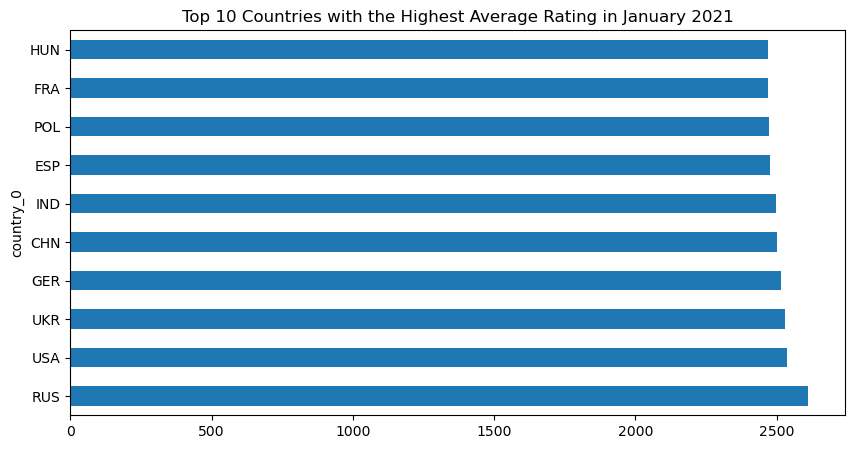

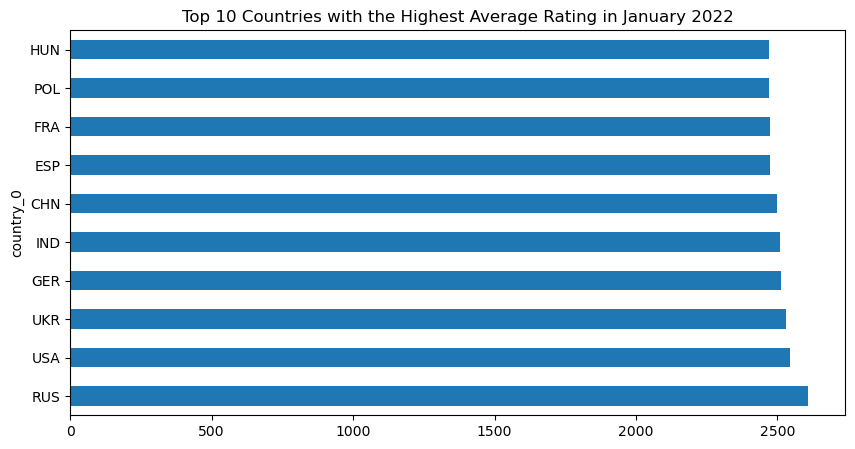

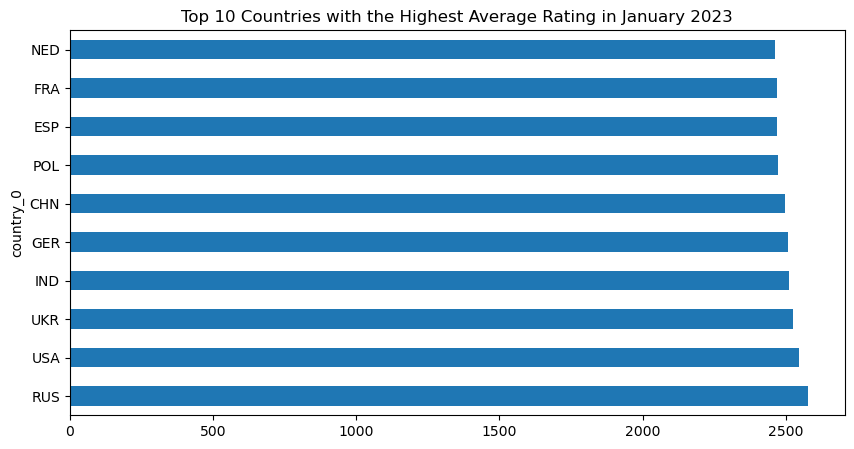

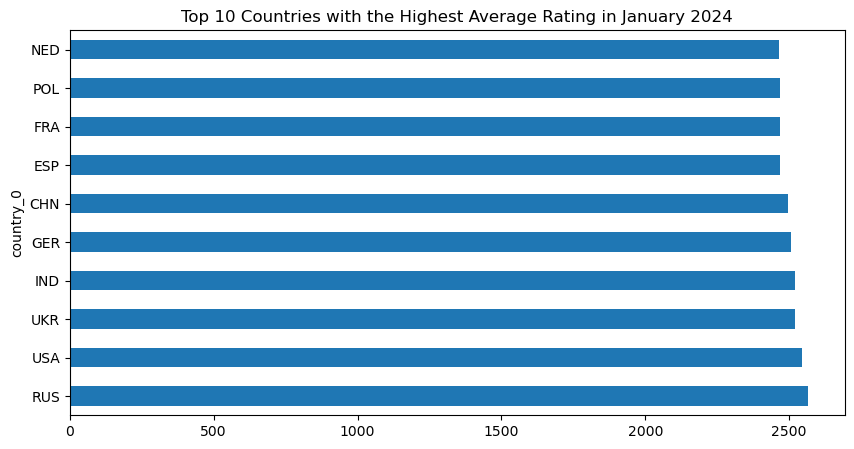

In [85]:
plt.figure(figsize=(20, 8))

plt.title('Top 10 Countries with the Highest Average Rating in January 2021')
plot1 = df_std_21['rating_0'].groupby(df_std_21['country_0']).apply(lambda x: x.nlargest(
    100).mean()).sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 5))
plt.show()

plt.title('Top 10 Countries with the Highest Average Rating in January 2022')
plot2 = df_std_22['rating_0'].groupby(df_std_22['country_0']).apply(lambda x: x.nlargest(
    100).mean()).sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 5))
plt.show()

plt.title('Top 10 Countries with the Highest Average Rating in January 2023')
plot3 = df_std_23['rating_0'].groupby(df_std_23['country_0']).apply(lambda x: x.nlargest(
    100).mean()).sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 5))
plt.show()

plt.title('Top 10 Countries with the Highest Average Rating in January 2024')
plot4 = df_std_24['rating_0'].groupby(df_std_24['country_0']).apply(lambda x: x.nlargest(
    100).mean()).sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 5))

plt.show()

Let's plot the top 10 players of Russia and see how strong they are.

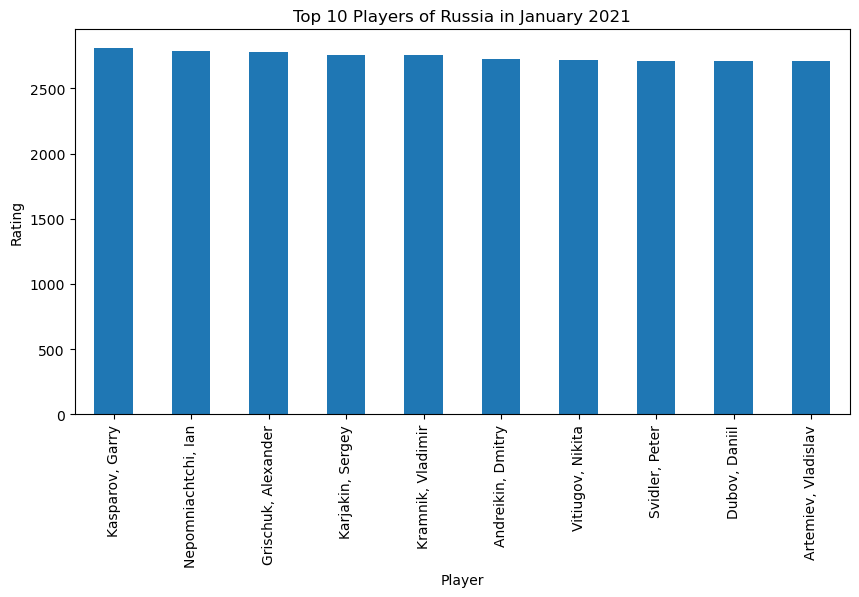

In [84]:
russian_players = df_std_21[df_std_21['country_0'] == 'RUS']

top_10_russian_players = russian_players.nlargest(10, 'rating_0')

plot_data = top_10_russian_players.set_index('name_0')['rating_0']

plt.figure(figsize=(10, 5))
plot = plot_data.plot(kind='bar')
plot.set_ylabel('Rating')
plot.set_xlabel('Player')
plot.set_title('Top 10 Players of Russia in January 2021')

plt.show()

These are all Russian, but who are the top players of the world?
#
Let's plot the top 10 players in the world and see how strong they are and where they are from...

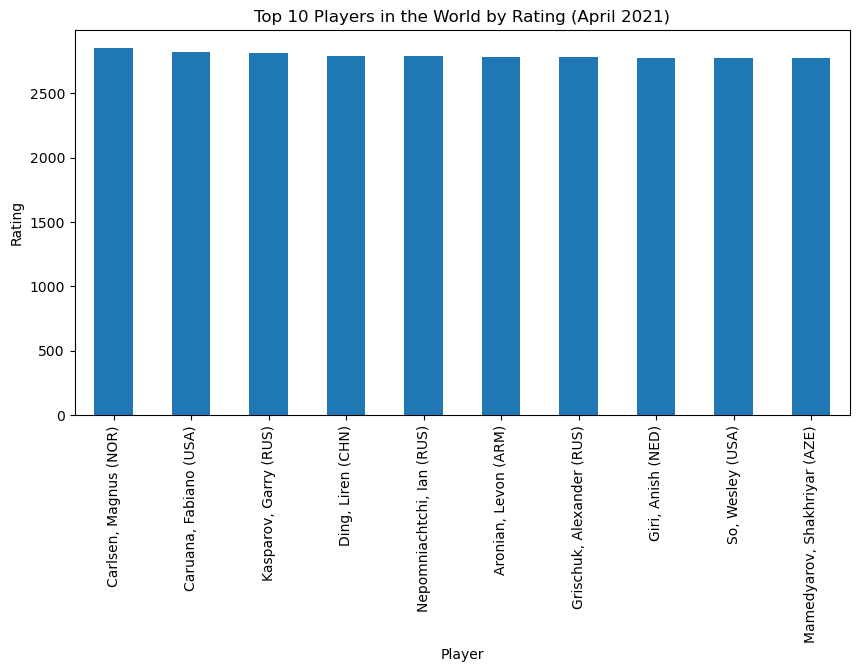

In [72]:
df_std_21['player_country'] = df_std_21['name_0'] + \
    ' (' + df_std_21['country_0'] + ')'

top_10_players = df_std_21.nlargest(10, 'rating_0')

plt.figure(figsize=(10, 5))
plot = top_10_players.set_index('player_country')['rating_0'].plot(kind='bar')
plot.set_ylabel('Rating')
plot.set_xlabel('Player')
plot.set_title('Top 10 Players in the World by Rating (January 2021)')

plt.show()


It seems like Russia has the best players also due to the fact that their top players have the highest ratings in top 10, and top 100 compared to the other countries

Now the next part is a fun plot. It makes no sense to make a K-means clustering for the player ratings for any year - but take a look at the tip - that is all the top 11.11% of the player base. Kind of crazy right? 2250 - 2850 rating (the single dot at the end being the GOAT - Magnus Carlsen)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rating_columns_2022 = [f'rating_{i}' for i in range(12)]

imputer = SimpleImputer(strategy='mean')
df_std_22_imputed = pd.DataFrame(imputer.fit_transform(df_std_22[rating_columns_2022]),
                                 columns=rating_columns_2022)

kmeans = KMeans(n_clusters=9, random_state=0).fit(df_std_22_imputed)


df_std_22['cluster'] = kmeans.labels_

/Users/ppch/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


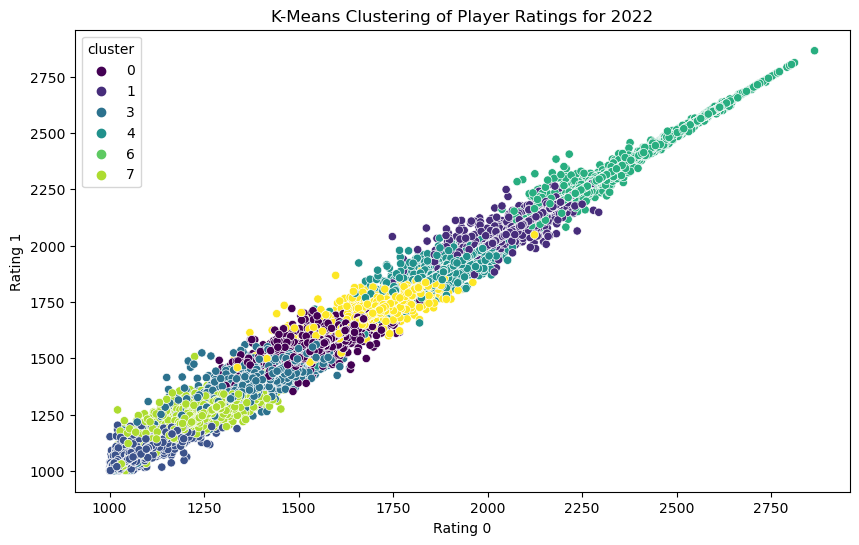

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_std_22, x='rating_0', y='rating_1', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of Player Ratings for 2022')
plt.xlabel('Rating 0')
plt.ylabel('Rating 1')
plt.show()


The linear alignment of clusters suggests a strong correlation between 'Rating 0' and 'Rating 1'. The K-Means algorithm has clustered the players primarily based on the magnitude of their ratings, with each cluster seemingly representing a tier of player skill or performance level.


Now how about finding out what sex is better at chess?

In [ ]:
import matplotlib.pyplot as plt

bins = 100 
hist_male = np.zeros(bins)
hist_female = np.zeros(bins)
bin_edges = np.linspace(start=0, stop=3000, num=bins+1)

for i in range(12):
    male_ratings = df_std_22[df_std_22[f'sex_{i}'] == 'M'][f'rating_{i}'].dropna()
    hist_male += np.histogram(male_ratings, bins=bin_edges)[0]
    
    female_ratings = df_std_22[df_std_22[f'sex_{i}'] == 'F'][f'rating_{i}'].dropna()
    hist_female += np.histogram(female_ratings, bins=bin_edges)[0]

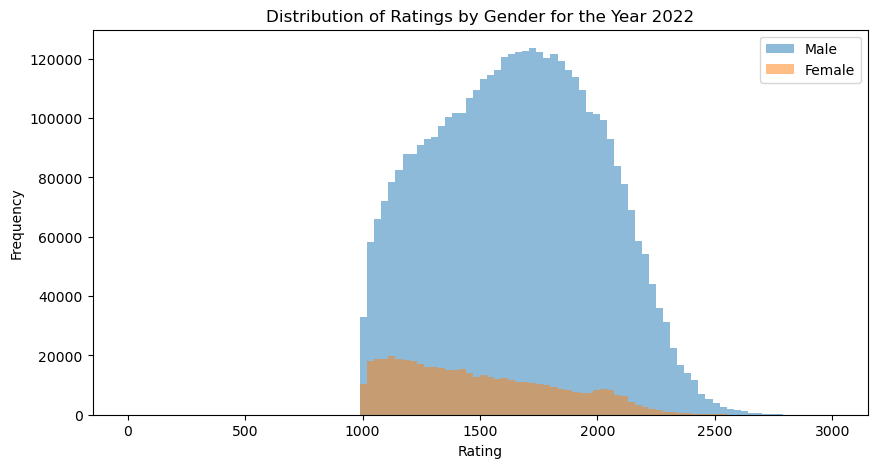

In [68]:
plt.figure(figsize=(10, 5))

bin_widths = np.diff(bin_edges)
plt.bar(bin_edges[:-1], hist_male, width=bin_widths, align='edge', alpha=0.5, label='Male')
plt.bar(bin_edges[:-1], hist_female, width=bin_widths, align='edge', alpha=0.5, label='Female')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings by Gender for the Year 2022')
plt.legend(loc='upper right')
plt.show()


The histogram shows a huge difference in the number of male (blue) versus female (orange) players across all rating levels, with male players overwhelmingly dominating the frequency counts in the mid-range ratings around 2000. Female players appear as a much smaller subset, indicating lower participation or representation within this dataset.

Now let's see it in a different graph - not as a histogram - as a "weird CDF"

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rating_columns = [f'rating_{i}' for i in range(12)]
gender_columns = [f'sex_{i}' for i in range(12)]

ratings_long = pd.melt(df_std_22, value_vars=rating_columns, var_name='Month', value_name='Rating')

genders_long = pd.melt(df_std_22, value_vars=gender_columns, var_name='Month', value_name='Gender')

long_format_data = pd.DataFrame({
    'Rating': ratings_long['Rating'],
    'Gender': genders_long['Gender']
})

/var/folders/0r/mh02trg51d7880t5fblpxd5w0000gn/T/ipykernel_92152/3132050445.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=long_format_data, x='Rating', hue='Gender', shade=True)
/Users/ppch/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


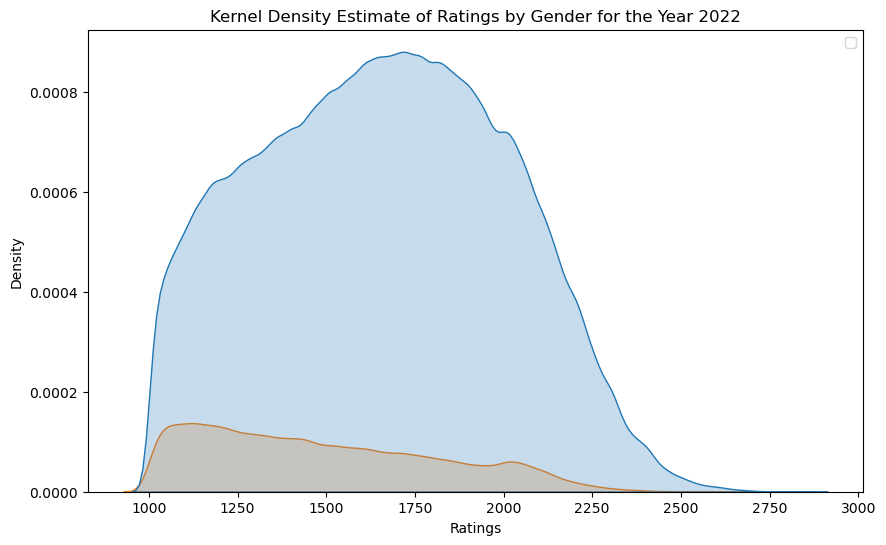

In [69]:
plt.figure(figsize=(10, 6))

sns.kdeplot(data=long_format_data, x='Rating', hue='Gender', shade=True)

plt.title('Kernel Density Estimate of Ratings by Gender for the Year 2022')
plt.xlabel('Ratings')
plt.ylabel('Density')
plt.legend()

plt.show()

This shows that females - even if the representation is lower - are present at the high ratings even if lower in numbers. The actual numbers are hard to read here since this is a density plot. We get that this might be very confusing, if you're seeing it for the first time - let's see a nice CDF curve instead...

In [ ]:
import numpy as np

male_ratings = [df_std_22[df_std_22[f'sex_{i}'] == 'M'][f'rating_{i}'] for i in range(12)]  # Replace with your data fetching
female_ratings = [df_std_22[df_std_22[f'sex_{i}'] == 'F'][f'rating_{i}'] for i in range(12)]  # Replace with your data fetching


male_ratings_flat = np.concatenate(male_ratings)
female_ratings_flat = np.concatenate(female_ratings)


male_ratings_sorted = np.sort(male_ratings_flat)
male_cdf = np.arange(1, len(male_ratings_sorted)+1) / len(male_ratings_sorted)


female_ratings_sorted = np.sort(female_ratings_flat)
female_cdf = np.arange(1, len(female_ratings_sorted)+1) / len(female_ratings_sorted)



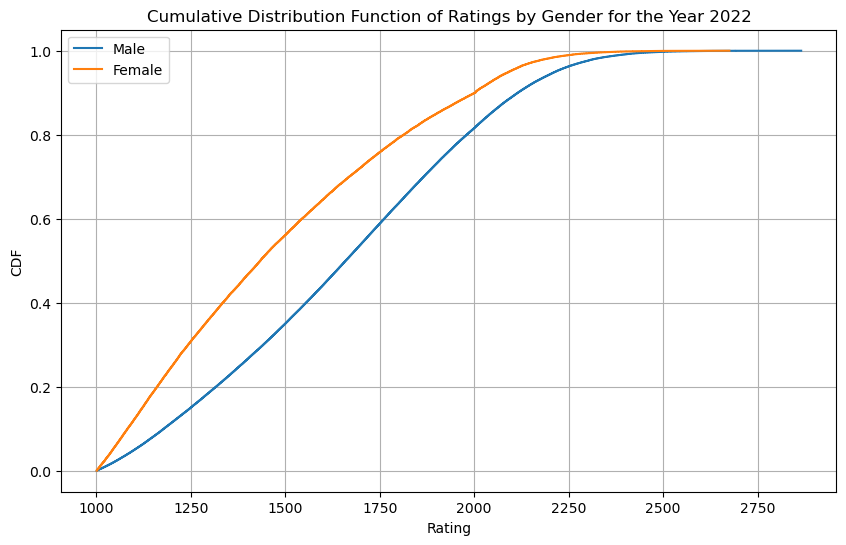

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(male_ratings_sorted, male_cdf, label='Male')
plt.plot(female_ratings_sorted, female_cdf, label='Female')

plt.title('Cumulative Distribution Function of Ratings by Gender for the Year 2022')
plt.xlabel('Rating')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


Lot to unpack here - The ratings distribution across genders suggests that there are more female players at the lower end of the rating spectrum, with a higher percentage of females falling into the lower rating categories compared to males. However, when it comes to the mid-rating level, the distribution of male and female players becomes more similar. Beyond this point, the male CDF continues to rise getting ahead of the female distribution, which tells us that there is a greater proportion of male players reaching the higher ratings. Overall, there are fewer female players, but they compete across all levels, including the top tiers of ratings.

Next - you can enjoy box-plots, and violin plots conveying pretty much the same information when put together, but in a simpler way...

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rating_columns = [f'rating_{i}' for i in range(12)]
gender_columns = [f'sex_{i}' for i in range(12)]

melted_ratings = pd.melt(df_std_22, value_vars=rating_columns, var_name='Month', value_name='Rating')
melted_genders = pd.melt(df_std_22, value_vars=gender_columns, var_name='Month', value_name='Gender')

full_year_data = pd.DataFrame({
    'Rating': melted_ratings['Rating'],
    'Gender': melted_genders['Gender']
}).dropna() 


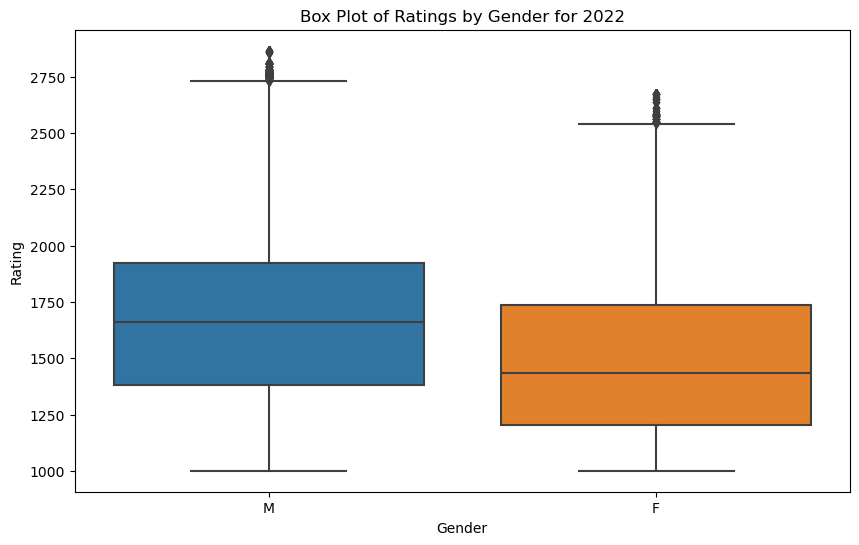

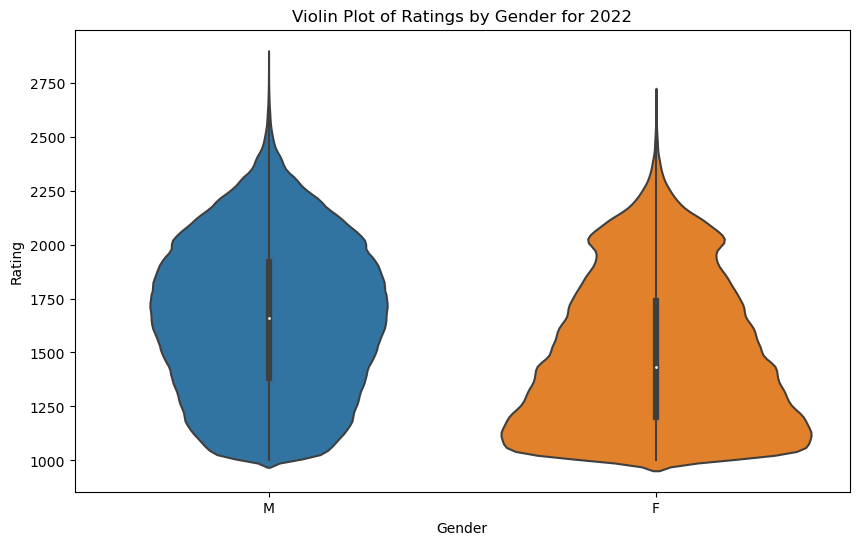

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Rating', data=full_year_data)
plt.title('Box Plot of Ratings by Gender for 2022')
plt.show()


plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Rating', data=full_year_data)
plt.title('Violin Plot of Ratings by Gender for 2022')
plt.show()


#

## 4. Some plots that didn't belong anywhere per se, but convey nice and useful information

How does the rating cdf change over the years?

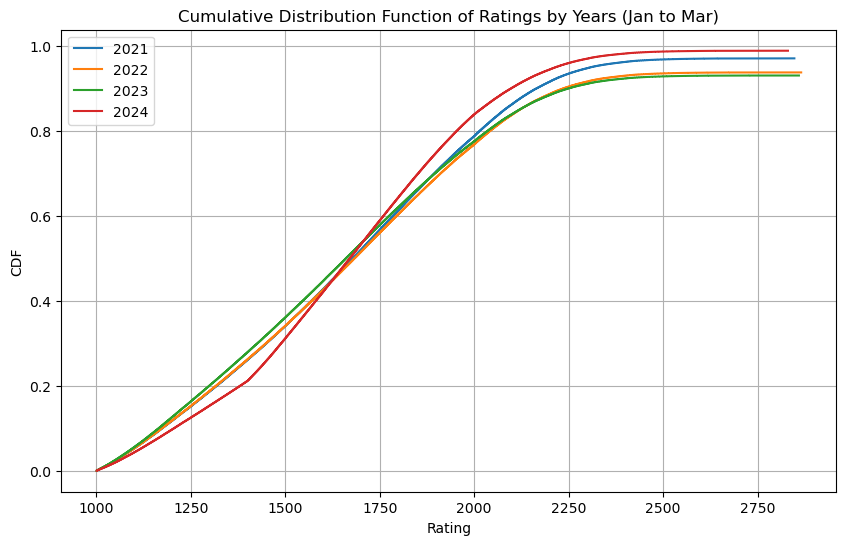

Counts for 2021: [     0 131743 162018 187919 210497 196436 144964  52801   8711    787
      9]
Counts for 2022: [     0 142469 174787 198434 216816 198729 144400  52533   8637    779
      9]
Counts for 2023: [     0 165061 201411 220709 230007 203592 143607  51786   8478    734
      7]
Counts for 2024: [     0 130489 155062 283097 302415 263926 143340  51204   8322    689
      9]


In [71]:
import numpy as np

def plot_cdf_from_ratings(dataframes, year_labels):
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dataframes, year_labels):
        ratings = np.ravel([df['rating_0'], df['rating_1'], df['rating_2']])
        sorted_ratings = np.sort(ratings)
        cdf = np.arange(1, len(sorted_ratings)+1) / len(sorted_ratings)
        plt.plot(sorted_ratings, cdf, label=label)
    
    plt.xlabel('Rating')
    plt.ylabel('CDF')
    plt.title('Cumulative Distribution Function of Ratings by Years (Jan to Mar)')
    plt.legend()
    plt.grid()
    plt.show()

plot_cdf_from_ratings([df_std_21, df_std_22, df_std_23, df_std_24], ['2021', '2022', '2023', '2024'])

bins = [0, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]


def count_players_in_bins(dataframes, bins):
    year_labels = ['2021', '2022', '2023', '2024']
    for df, label in zip(dataframes, year_labels):
        ratings = np.ravel([df['rating_0'].values, df['rating_1'].values, df['rating_2'].values])
        counts, _ = np.histogram(ratings, bins)
        
        print(f"Counts for {label}: {counts}")


count_players_in_bins([df_std_21, df_std_22, df_std_23, df_std_24], bins)


How do the first 3 months of each year look with the changed rating system in March 2024?

/var/folders/0r/mh02trg51d7880t5fblpxd5w0000gn/T/ipykernel_92152/3593063106.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[f'rating_{i}'], label=f'{year} - Month {i+1}', shade=True, color=color, alpha=0.3)
/Users/ppch/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/0r/mh02trg51d7880t5fblpxd5w0000gn/T/ipykernel_92152/3593063106.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[f'rating_{i}'], label=f'{year} - Month {i+1}', shade=True, color=color, alpha=0.3)
/Users/ppch/miniconda3/lib/python3.10/site-pack

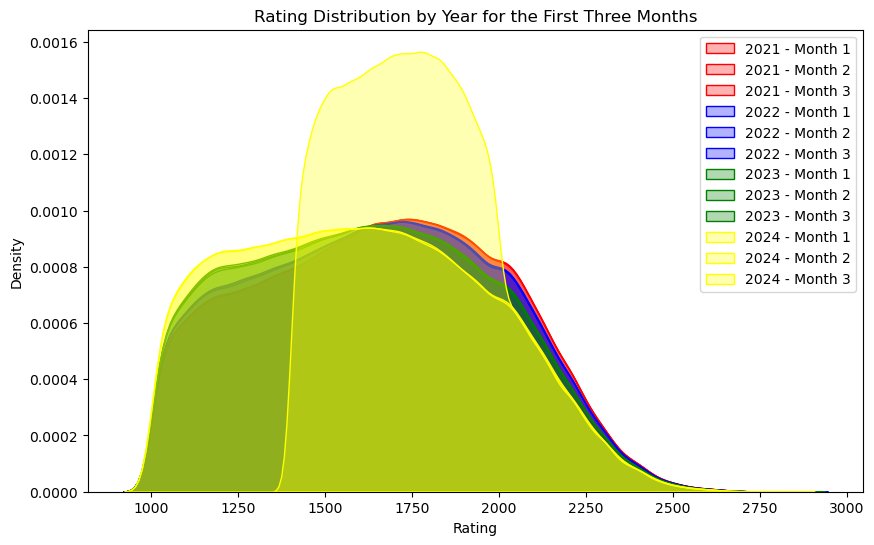

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'green', 'yellow']
years = ['2021', '2022', '2023', '2024']
dataframes = [df_std_21, df_std_22, df_std_23, df_std_24]


for df, year, color in zip(dataframes, years, colors):
    for i in range(3):
        sns.kdeplot(df[f'rating_{i}'], label=f'{year} - Month {i+1}', shade=True, color=color, alpha=0.3)

plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Rating Distribution by Year for the First Three Months')
plt.legend()
plt.show()


How do the rating distributions shift over the years?

/var/folders/0r/mh02trg51d7880t5fblpxd5w0000gn/T/ipykernel_92152/1619953416.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_std_21['rating_0'], label='2021', shade=True, color='red')
/Users/ppch/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/0r/mh02trg51d7880t5fblpxd5w0000gn/T/ipykernel_92152/1619953416.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_std_22['rating_0'], label='2022', shade=True, color='blue')
/Users/ppch/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

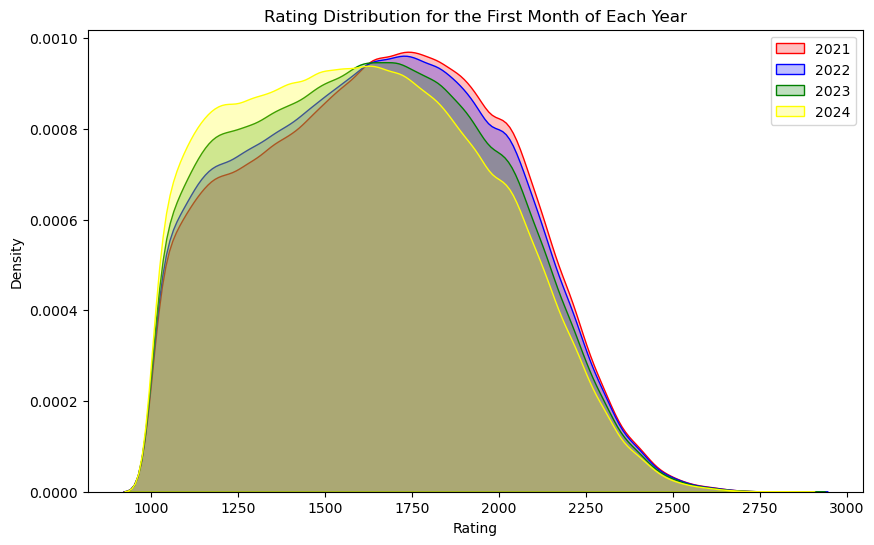

In [41]:
plt.figure(figsize=(10, 6))

sns.kdeplot(df_std_21['rating_0'], label='2021', shade=True, color='red')

sns.kdeplot(df_std_22['rating_0'], label='2022', shade=True, color='blue')

sns.kdeplot(df_std_23['rating_0'], label='2023', shade=True, color='green')

sns.kdeplot(df_std_24['rating_0'], label='2024', shade=True, color='yellow')

plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Rating Distribution for the First Month of Each Year')
plt.legend()

plt.show()


In [ ]:
data = []

for i in range(9):
    for rating in df_std_21[f'rating_{i}']:
        data.append(('2021', rating))

for year, df in [('2022', df_std_22), ('2023', df_std_23)]:
    for i in range(12):
        for rating in df[f'rating_{i}']:
            data.append((year, rating))

for i in range(3):
    for rating in df_std_24[f'rating_{i}']:
        data.append(('2024', rating))

combined_ratings_df = pd.DataFrame(data, columns=['Year', 'Ratings'])

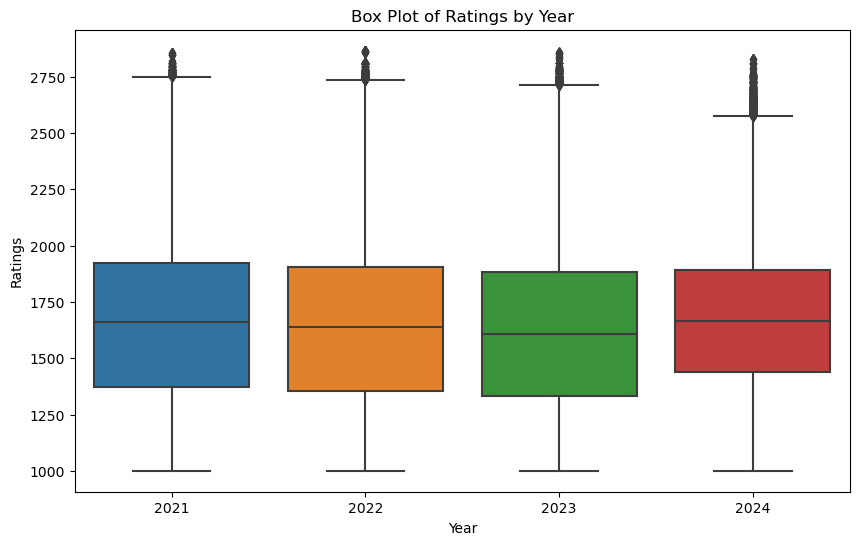

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Ratings', data=combined_ratings_df)
plt.title('Box Plot of Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Ratings')
plt.show()
